In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import sys

blocking_dir='/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV'
sys.path.append(blocking_dir)
import block

In [2]:
errmethod = 'hline' #for blocking


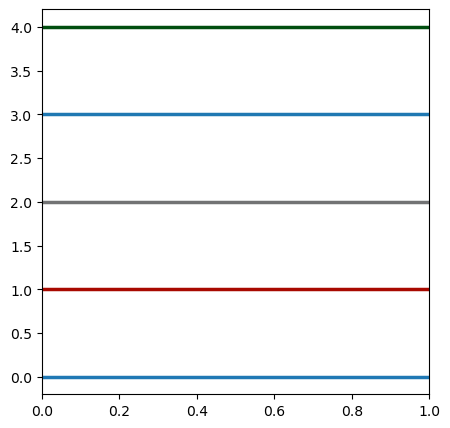

In [3]:
from matplotlib.colors import LinearSegmentedColormap

#new_cmap = ['#1b9e77', '#d95f02', '#7570b3', '#1f78b4', '#ca0020']
new_cmap= ['#1f78b4', '#A80900', '#737373', '#1f78b4', '#004e0f'] 
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,5))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [4]:
#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

def block_err_analysis(CV, errmethod):
    ##Block error anaylsis
    
    #Trim Rg array for block error analysis
    CV = block.check(CV, multi=1)

    #Block error analysis
    blocks_stat = block.blocking(CV)

    #Choose optimal block size and find error
    if errmethod=='b3':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="b3")
    elif errmethod=='knee_loc':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="knee_loc",S=2.7)
    elif errmethod=='hline':
        corr_len, err = block.optimal_block(len(CV),blocks_stat,method="hline")
        
    return corr_len, err, blocks_stat

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_2897184/666530413.py:12: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi_{eff}$', fontsize=20)
/tmp/ipykernel_2897184/666530413.py:13: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('$\chi^2_r$', fontsize=20)


78.47599703514607 0.882958639668312 1.0226802360061629


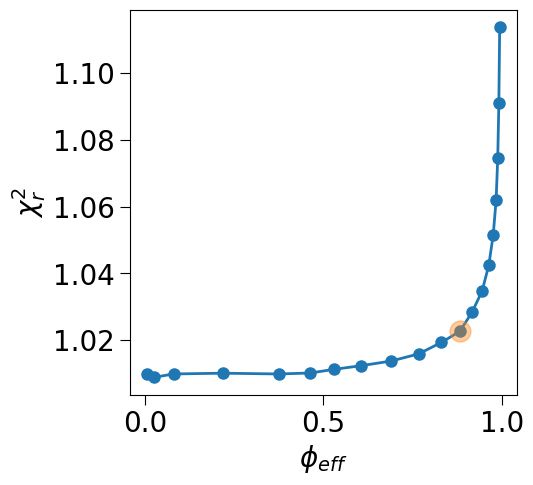

In [5]:
theta_sel_AB_SAXS=11

reweighting_results_AB = load_pickle('4_reweighting/reweighting.pkl')
fig = plt.figure(figsize=(5,5))

plt.plot(reweighting_results_AB['phi'], reweighting_results_AB['chi2'], 'o-', lw=2, ms=8)

theta_sel_val = reweighting_results_AB['theta'][theta_sel_AB_SAXS]
print(theta_sel_val, reweighting_results_AB['phi'][theta_sel_AB_SAXS], reweighting_results_AB['chi2'][theta_sel_AB_SAXS])
plt.plot(reweighting_results_AB['phi'][theta_sel_AB_SAXS], reweighting_results_AB['chi2'][theta_sel_AB_SAXS], 'o', ms=15, alpha=0.4, label=f'{theta_sel_val}')

plt.xlabel('$\phi_{eff}$', fontsize=20)
plt.ylabel('$\chi^2_r$', fontsize=20)
plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

fig.savefig("figures/SAXS_thetascan.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

save_pickle('4_reweighting/weights.pkl', reweighting_results_AB['weights'][theta_sel_AB_SAXS])

In [6]:
#Compare with CALVADOS on AB alone
weights_AB = load_pickle('4_reweighting/weights.pkl')[10:]
weights_AB /= np.sum(weights_AB)
SAXS_AB = load_sim_SAXS('4_reweighting/calc_SAXS.dat')[10:] 
#SKIPPING FIRST 10 FRAMES EVEN THOUGH THEY WERE USED IN REWEIGHTING

chi2 before: 1.391673564743312, chi2 after: 1.0220799174351634


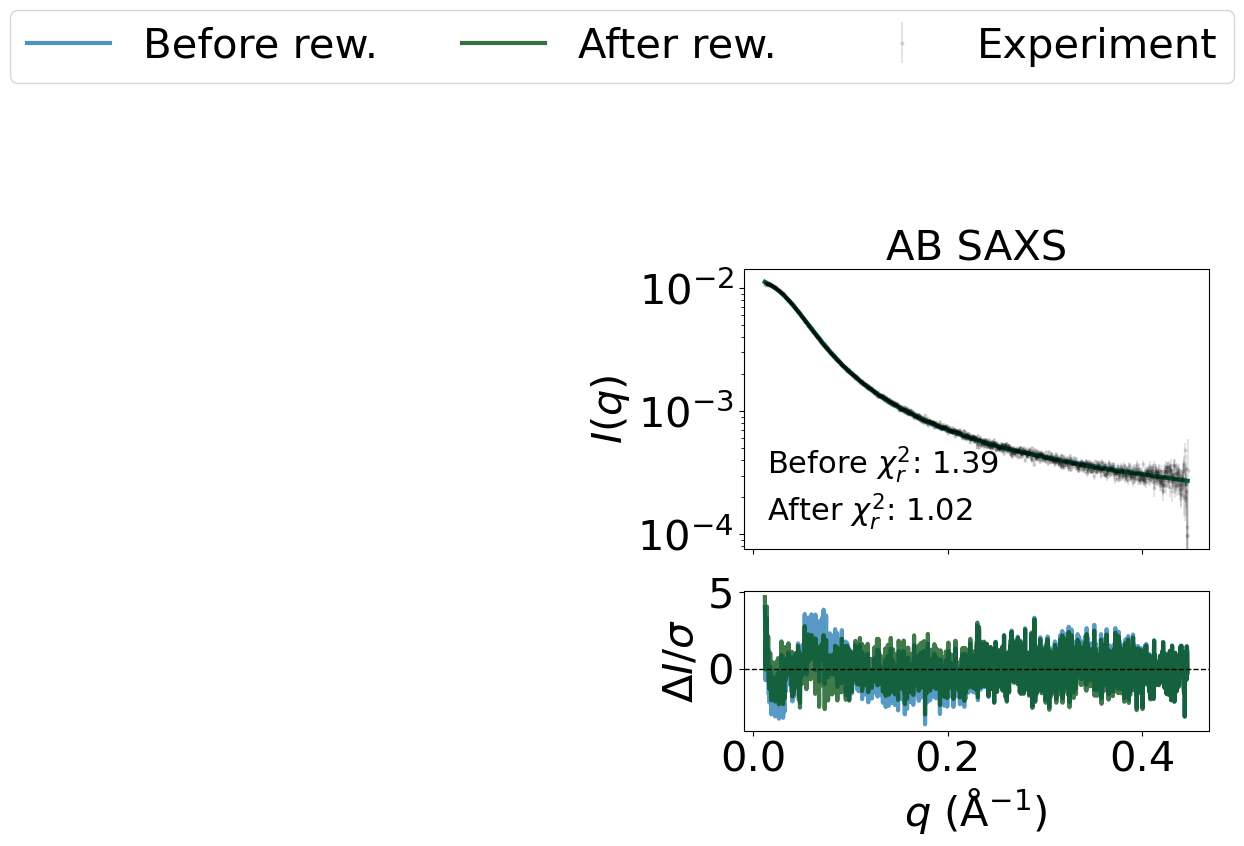

In [7]:
SAXS_AB_avg = np.average(SAXS_AB, axis=0)
SAXS_AB_avg_rew = np.average(SAXS_AB, axis=0, weights=weights_AB)

q, I_exp, err_exp = load_exp_SAXS('4_reweighting/PPARa_AB_SAXSexpt.dat')
q *= 0.1

SAXS_AB_avg_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_AB_avg, I_exp, err_exp)
SAXS_AB_avg_rew_scaleoffset, slope, intercept, r_value = fit_scale_offset(SAXS_AB_avg_rew, I_exp, err_exp)

chi2 = get_chi2(SAXS_AB_avg_scaleoffset, I_exp, err_exp)
chi2_rew = get_chi2(SAXS_AB_avg_rew_scaleoffset, I_exp, err_exp)

print(f'chi2 before: {chi2}, chi2 after: {chi2_rew}')

residuals = (SAXS_AB_avg_scaleoffset-I_exp)/err_exp
residuals_rew = (SAXS_AB_avg_rew_scaleoffset-I_exp)/err_exp

#SAXS figure
fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

ax[0].set_title('AB SAXS', fontsize=30)

ax[0].errorbar(q, I_exp, yerr=err_exp, fmt='o', markersize=2, color='black', alpha=0.1, label='Experiment')
ax[0].plot(q, SAXS_AB_avg_scaleoffset, linewidth=3, label="Before rew.", alpha=0.8, color=colors[3])
ax[0].plot(q, SAXS_AB_avg_rew_scaleoffset, linewidth=3, label="After rew.", alpha=0.8, color=colors[4])

ax[0].semilogy()
ax[0].set_ylabel('$I(q)$', fontsize=30)
ax[0].legend(fontsize=30, ncol=6, bbox_to_anchor=(1.1, 2.0))
ax[0].text(0.05,0.10, f'Before $χ^2_r$: {chi2:.2f} \nAfter $χ^2_r$: {chi2_rew:.2f}', fontsize=22, transform=ax[0].transAxes)

for j in range(len(ax)):
    ax[j].tick_params(axis='both', which='major', labelsize=30)

ax[1].plot(q, residuals, linewidth=3, color= colors[3], alpha=0.75)
ax[1].plot(q, residuals_rew, linewidth=3, color= colors[4], alpha=0.75)

ax[1].set_ylabel('$ΔI/σ$', fontsize=30)
ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=30)
ax[1].axhline(0, ls='--', linewidth=1, color='black')

fig.savefig("figures/SAXS_rew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

3.093005264470101 3.0725381301986743
Possible blocks transformations: 20
 no lenght correction needed

Before rew: 3.0371485124879225 +- 0.01047387738200945
After rew: 3.0364605377679394 +- 0.01047387738200945


/projects/prism/people/hzr104/software/BLOCKING_OLD/MonoCV/block.py:59: RuntimeWarning: invalid value encountered in scalar divide
  err = np.sqrt( ((blocks_av - u)**2).sum() / (Nb*(Nb-1)) )


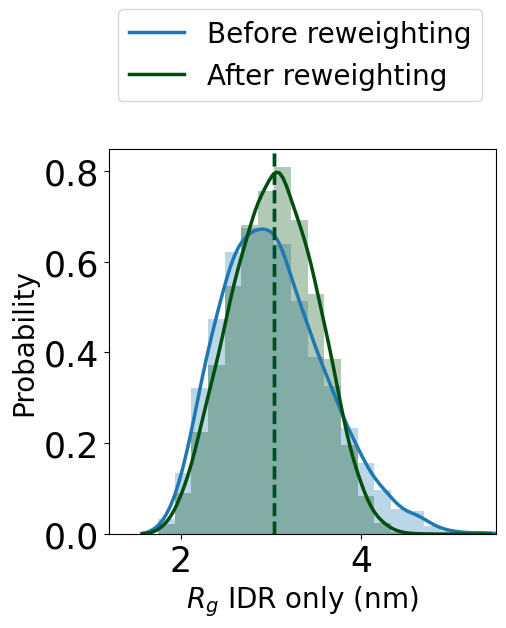

In [8]:
Rg_AB = np.load('trajectory_CG/rg.npy')

fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB)*1.1, num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman").evaluate(kde_x)

plt.hist(Rg_AB, density=True, color=colors[3], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[3], label='Before reweighting')

plt.axvline(x=np.average(Rg_AB), ls='--', linewidth=2.5, alpha=1, color=colors[3])

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB), num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman", weights=weights_AB).evaluate(kde_x)

plt.hist(Rg_AB, weights=weights_AB, density=True, color=colors[4], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[4], label='After reweighting')

plt.axvline(x=np.average(Rg_AB, weights=weights_AB), ls='--', linewidth=2.5, alpha=1, color=colors[4])

plt.legend(fontsize=20, bbox_to_anchor=(1.0, 1.4))
plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ IDR only (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.xlim(1.2, 5.5)

fig.savefig(f"figures/Rg_histogram_beforeafterrew.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

#print(np.average(Rg_AB), np.average(Rg_AB, weights=weights_AB))
print(np.sqrt(np.average(np.square(Rg_AB))), np.sqrt(np.average(np.square(Rg_AB), weights=weights_AB)))

corr_len, err_Rg_AB, blocks_stat = block_err_analysis(Rg_AB, errmethod)
print(f'Before rew: {np.average(Rg_AB)} +- {err_Rg_AB}')

print(f'After rew: {np.average(Rg_AB, weights=weights_AB)} +- {err_Rg_AB}')


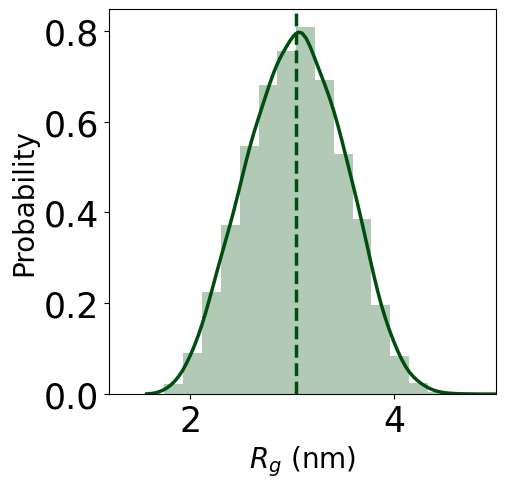

In [9]:
fig = plt.figure(figsize=(5,5))

#KDE
kde_x = np.linspace( np.amin(Rg_AB)*0.9, np.amax(Rg_AB), num = 100 )
kde_y = stats.gaussian_kde(Rg_AB, bw_method = "silverman", weights=weights_AB).evaluate(kde_x)

plt.hist(Rg_AB, weights=weights_AB, density=True, color=colors[4], alpha=0.3, bins=20)
plt.plot(kde_x, kde_y, '-', linewidth=2.5, color=colors[4], label='After reweighting')

plt.axvline(x=np.average(Rg_AB, weights=weights_AB), ls='--', linewidth=2.5, alpha=1, color=colors[4])

plt.tick_params(axis='both', which='major', labelsize=25)

plt.xlabel('$R_g$ (nm)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

plt.xlim(1.2,5)

fig.savefig(f"figures/Rg_histogram.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
